# DGCNN : An experimentation

## By Nil-Dany MOSTEFAI and Elhadi CHITER

This project is an experiment with the architecture DGCNN presented in the paper [Dynamic Graph CNN for Learning on Point Clouds](https://arxiv.org/pdf/1801.07829).

We will implement a modulable DGCNN, and will study the impacts of the architecture, the data, the training hyperparameters on the performances for a classification task on the ModelNet40 dataset.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from ply import write_ply, read_ply
import random
import wandb

## Utils

In [2]:
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),      0],
                               [ math.sin(theta),  math.cos(theta),      0],
                               [0,                               0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud 

class RandomScaling(object) : 
    def __call__(self, pointcloud):
        t = np.random.uniform(0.8, 1.2, (1, 3))
        return pointcloud * t

class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)


def default_transforms():
    return transforms.Compose([RandomRotation_z(),RandomNoise(), ToTensor()])
def my_transform():
    return transforms.Compose([RandomNoise(), RandomScaling(), ToTensor()])

def test_transforms():
    return transforms.Compose([ToTensor()])



class PointCloudData_RAM(Dataset):
    def __init__(self, root_dir, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.data = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    ply_path = new_dir+"/"+file
                    data = read_ply(ply_path)
                    sample = {}
                    sample['pointcloud'] = np.vstack((data['x'], data['y'], data['z'])).T
                    sample['category'] = self.classes[category]
                    self.data.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pointcloud = self.transforms(self.data[idx]['pointcloud'])
        return {'pointcloud': pointcloud, 'category': self.data[idx]['category']}




## EdgeConv

Here, we define our DGCNN.

First we will define a function build_knn which outputs the indexes of the k nearest neighbors of each point in the point clouds.

The second function build_graph will build the corresponding graph, that is, a graph of shape [B, F * 2, N, k] where F is the dimension of the point cloud. For one sample n in the b-th point cloud in the batch, the associated matrix is a matrix [F*2, k] where for each neighbor j, we get the value of this neighbor and the value of the difference with this neighbor.

From this we can define an EdgeConv Layer, that is, a Conv2d layer, followed by a BatchNorm layer, and a ELU activation function. Note that we compute the graph at the start of each call of EdgeConv layer, and the convolution take F * 2 channels.

Finally, we define DGCNN "almost" like what is presented in the paper.


In [3]:
device = "cpu"
toy = torch.randn(2, 1024, 3,)

In [4]:
def build_knn(x, k):
    """
    Returns the indices of the k nearest neighbors for each point in x.
    ---Args:
        x : [B x N x 3] a batch of point clouds.
        k : int, a number of neighbors
    ---Outputs:
        indices : [B x N x k] a tensor of the k nearest neighbors.
    """
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def build_graph(x, k=20, idx=None):
    """
        Returns the parameters to create the edge features
        ---Args:
            x : [B x N x 3] a batch of point clouds.
            idx : [B x N x k]
        ---Outputs:
            Graph features: [B x 2F x N x k] given a batch, a point x_i and a neighbor of this point x_j, the associated vector of size 2F is:
            [x_j - x_i, x_i].
    """
    x = x.transpose(1, 2)
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = build_knn(x, k=k)   # (batch_size, num_points, k)

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

In [5]:
feature = build_graph(toy.to(device), 10)

In [6]:
feature.shape

torch.Size([2, 6, 1024, 10])

In [7]:
class EdgeConv(nn.Module):
    
    def __init__(self,start_dim, end_dim,  k, momentum = 0.1):
        super(EdgeConv, self).__init__()
        self.k = k
        self.conv1 = nn.Sequential( 
                        nn.Conv2d(start_dim , end_dim, 1),
                        nn.BatchNorm2d(end_dim, momentum = momentum),
                        nn.ReLU())
    def forward(self, x):
        feature = build_graph(x, self.k)
        feature = self.conv1(feature)
        return feature.max(dim = -1, keepdim = False)[0].transpose(1, 2)
        
class DGCNN(nn.Module):
    def __init__(self, output_channels, k = 5, dropout = 0.3, momentum = 0.1):
        super(DGCNN, self).__init__()
        self.conv1 = EdgeConv(6, 64, k, momentum = momentum)
        self.conv2 = EdgeConv(64*2, 64, k, momentum = momentum)
        self.conv3 = EdgeConv(64*2, 128, k, momentum = momentum)
        self.conv4 = EdgeConv(128 * 2, 256, k, momentum = momentum)
        self.conv5 = nn.Sequential(nn.Conv1d(512, 1024, 1),
                                   nn.BatchNorm1d(1024, momentum = momentum),
                                   nn.ReLU())
        self.mlp = nn.Sequential(
            nn.Linear(1024 * 2, 512),
            nn.BatchNorm1d(512, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_channels,)
        )
    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        
        x4 = self.conv4(x3)
        x5 = torch.concat((x1, x2, x3, x4), dim = -1).transpose(1, 2)
        x5 = self.conv5(x5)
        X1 = F.max_pool1d(x5, 1024).squeeze(-1)
        X2 = F.avg_pool1d(x5, 1024).squeeze(-1)
        return self.mlp(torch.cat((X1, X2), dim = -1)), None

In [8]:
model = DGCNN(40).to(device)
model(toy.to(device))[0]

tensor([[ 0.2796,  0.0569,  0.0563,  0.4797, -0.0954, -0.2140, -0.6115, -0.6919,
         -0.5401,  0.5669,  0.4351,  0.6247,  0.0655, -0.1428,  0.0082,  0.1741,
         -0.7516, -0.1459, -0.3501, -0.5226, -0.9415,  0.3033,  0.1171,  0.5849,
          0.6241, -0.0919,  0.4525, -0.3087,  0.4671,  0.9341,  0.8430,  0.2516,
         -0.1087, -0.5898, -0.5702, -0.6701, -0.0254, -0.5413,  0.2021,  0.3451],
        [ 0.3601,  1.2487,  0.2932,  0.1900,  1.4555,  0.2696, -0.1835,  0.8039,
         -0.1458, -0.2563,  0.1754,  0.4269,  0.2853, -0.0047,  0.1133,  0.0587,
          0.3335,  0.5712, -0.1764, -0.1793, -0.5026,  0.0341,  0.2037, -0.0906,
          0.0773, -0.6499,  0.4611,  0.3065, -0.0964, -0.3214,  0.2359, -0.0430,
          0.4384, -0.6755, -0.3329, -0.0895,  0.3774, -0.4088, -0.1319, -0.1384]],
       grad_fn=<AddmmBackward0>)

In [9]:
print("Number of parameters : ", sum([p.numel() for p in DGCNN(40).parameters()]))

Number of parameters :  1811624


## Training

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
def loss_model_basic(outputs, labels):
    criterion = torch.nn.CrossEntropyLoss(reduction = "mean")
    return criterion(outputs, labels)


def loss_model_transform(outputs, labels, m3x3, alpha = 0.0001):
    criterion = torch.nn.CrossEntropyLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)) / float(bs)


In [12]:

def train(model, train_loader, test_loader, n_epochs = 100, lr = 1e-3, step_size = 15, alpha = 0.0001,
          gamma = 0.5, train_transform = False, model_name = "base",):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma )
    loss = 0
    losses_train = []
    losses_test = []
    pbar =  trange(n_epochs)
    accuracies = []
    accuracy_max = 0
    path = "models/" + model_name
    if not os.path.isdir(path):
        os.makedirs(path)
    try:
        for epoch in pbar:
            loss_batch = 0
            model.train()
            for data in (train_loader):
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                optimizer.zero_grad()
                output, matrix = model(inputs)
                if not train_transform:
                    loss = loss_model_basic(output, labels)
                else:
                    loss = loss_model_transform(output, labels, matrix, alpha = alpha)
                loss.backward()
                optimizer.step()
                loss_batch += loss.item() / train_loader.batch_size
            scheduler.step()
            loss_batch /= len(train_loader)
            losses_train.append(loss_batch)
            loss_batch = 0
            model.eval()
            with torch.no_grad():
                accuracy = 0
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    output, matrix = model(inputs)
                    if not train_transform:
                        loss =loss_model_basic(output, labels)
                    else:
                        loss =loss_model_transform(output, labels, matrix,alpha = alpha)
                    loss_batch += loss.item() / test_loader.batch_size
                    accuracy += (torch.argmax(output, dim = -1) == labels).sum() / test_loader.batch_size
                accuracy = accuracy.item() / len(test_loader)
                loss_batch /= len(test_loader)
                losses_test.append(loss_batch)
                accuracies.append(accuracy)
                if accuracy_max < accuracy:
                    torch.save(model.state_dict(), path + "/Model.pth")
                    accuracy_max = accuracy
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            pbar.set_description(f"Epoch {epoch}")
            pbar.set_postfix(loss_train = losses_train[-1], loss_test = losses_test[-1], accuracy = accuracy)
    except KeyboardInterrupt:
        print("Interruption")
    pbar.close()
    return losses_train, losses_test, accuracies

In [13]:
def load_data(transforms = test_transforms, num_workers = 1):
    ROOT_DIR = "./data/ModelNet40_PLY"
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    print("Device: ", device)
    
    train_ds = PointCloudData_RAM(ROOT_DIR, folder='train', transform=transforms(),)
    test_ds = PointCloudData_RAM(ROOT_DIR, folder='test', transform=test_transforms())
    print(test_ds[0]['pointcloud'].shape)
    print(test_ds[1]['pointcloud'].shape)
    inv_classes = {i: cat for cat, i in train_ds.classes.items()}
    print("Classes: ", inv_classes)
    print('Train dataset size: ', len(train_ds))
    print('Test dataset size: ', len(test_ds))
    print('Number of classes: ', len(train_ds.classes))
    print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
    
    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers = num_workers)
    test_loader = DataLoader(dataset=test_ds, batch_size=32, pin_memory = True, num_workers = num_workers)
    return train_ds, test_ds, train_loader, test_loader, inv_classes
_, _, train_loader, test_loader, inv_classes = load_data()

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


## Base model

For this first model, we will train in during 100 epochs. We've implemented a complex training function equipped with an early stopper.

In [159]:
model = DGCNN(len(inv_classes)).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 100, gamma = 0.7, lr = 1e-2, step_size = 5, save_step = 5, patience = 2)

Epoch 99: 100%|███████████████| 100/100 [1:26:22<00:00, 51.83s/it, accuracy=0.864, loss_test=0.0196, loss_train=0.00122]


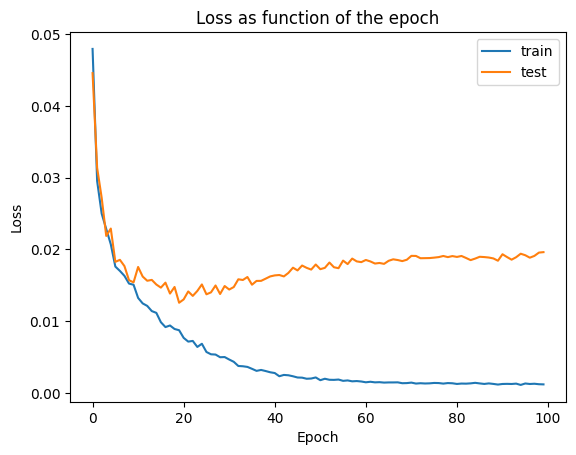

In [169]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss as function of the epoch")
plt.plot(losses_train, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.savefig("Losses_model_base")


In [ ]:
model = DGCNN(len(inv_classes)).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 100, gamma = 0.7, lr = 0.1, step_size = 5, save_step = 5, patience = 2)

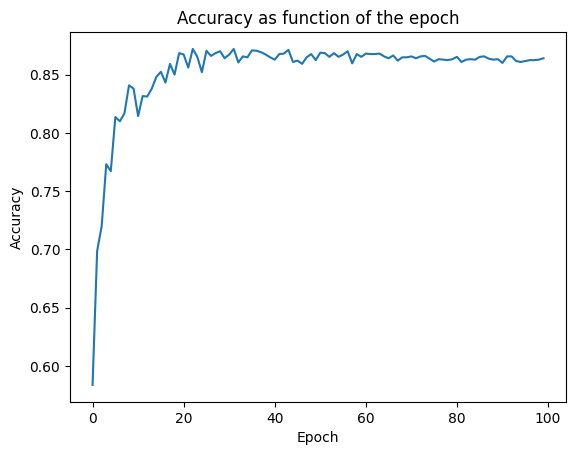

In [170]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as function of the epoch")
plt.plot(accuracies)
plt.savefig("Accuracies_model_base")

In [172]:
print(f"Best accuracy is : {np.max(accuracies):.3f}")

Best accuracy is : 0.872


In [19]:
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        accuracy = 0
        loss_batch = 0
        for data in test_loader:
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            output, matrix = model(inputs)
            loss =loss_model_basic(output, labels)
            loss_batch += loss.item() / train_loader.batch_size
            accuracy += (torch.argmax(output, dim = -1) == labels).sum() / test_loader.batch_size
        accuracy = accuracy.item() / len(test_loader)
        loss_batch /= len(test_loader)
        return loss_batch, accuracy

## Data Augmented model

For each training sample, we will perform a random rotation followed by an adding of a random noise.

In [18]:
_, _, train_loader, test_loader, inv_classes = load_data(transforms = default_transforms)

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


In [21]:
model = DGCNN(len(inv_classes)).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 100, gamma = 0.9, lr = 0.01, step_size = 5, save_step = 5, patience = 2)

Epoch 99: 100%|███████████████| 100/100 [2:08:08<00:00, 76.89s/it, accuracy=0.867, loss_test=0.0164, loss_train=0.00689]


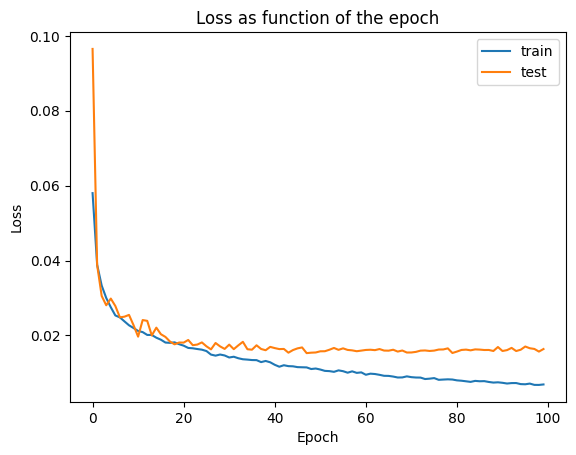

In [23]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss as function of the epoch")
#plt.xticks(np.arange(0, len(losses_train)))
plt.plot(losses_train, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.savefig("Losses_model_augmented")


In [28]:
print(f"Best accuracy is : {np.max(accuracies):.3f}")

Best accuracy is : 0.872


# K = 10



In [14]:
_, _, train_loader, test_loader, inv_classes = load_data(transforms = default_transforms)

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


In [16]:
model = DGCNN(len(inv_classes), momentum = 0.9, k = 10).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 60, gamma = 0.9, lr = 0.01, step_size = 5,
                                               patience = 2, train_transform = False, model_name = "K10")

Epoch 59: 100%|████████████████| 60/60 [2:04:55<00:00, 124.93s/it, accuracy=0.819, loss_test=0.0244, loss_train=0.00788]


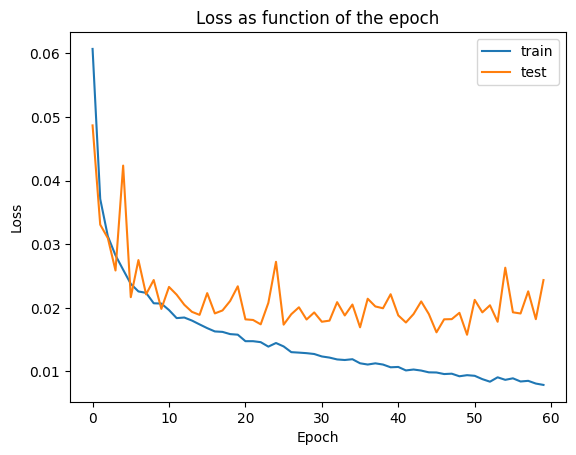

In [20]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss as function of the epoch")
#plt.xticks(np.arange(0, len(losses_train)))
plt.plot(losses_train, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.savefig("Losses_model_k10")


In [21]:
np.max(accuracies)

0.8537660256410257

## Point cloud transform

In [266]:
class Transform(nn.Module):
    def __init__(self, start_dim = 6, hidden_dim = 64, k = 5, momentum = 0.1):
        super(Transform, self).__init__()
        self.k = k
        self.conv1 = nn.Sequential(
            nn.Conv2d(start_dim, hidden_dim, 1),
            nn.BatchNorm2d(hidden_dim, momentum = momentum),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim *2 , 1),
            nn.BatchNorm1d(hidden_dim * 2, momentum = momentum),
            nn.ReLU(),
        )
        self.size = start_dim // 2
        self.mlp = nn.Sequential( 
                    nn.Linear(hidden_dim * 2 , hidden_dim ),
                    nn.BatchNorm1d(hidden_dim , momentum = momentum,),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, self.size ** 2)
        )
        
    def forward(self, x):
        x_graph = build_graph(x, self.k)
        feature = self.conv1(x_graph).max(dim = -1)[0]
        feature = self.conv2(feature).max(dim = -1)[0]
        feature = self.mlp(feature)
        matrix = feature.reshape((-1, self.size, self.size))
        
        return matrix

class DGCNN(nn.Module):
    def __init__(self, output_channels, k = 5, dropout = 0.3, momentum = 0.1):
        super(DGCNN, self).__init__()
        self.transform = Transform(6 , 64, k)
        self.conv1 = EdgeConv(6, 64, k, momentum = momentum)
        self.conv2 = EdgeConv(64*2, 64, k, momentum = momentum)
        self.conv3 = EdgeConv(64*2, 128, k, momentum = momentum)
        self.conv4 = EdgeConv(128 * 2, 256, k, momentum = momentum)
        self.conv5 = nn.Sequential(nn.Conv1d(512, 1024, 1),
                                   nn.BatchNorm1d(1024, momentum = momentum),
                                   nn.ReLU())
        self.mlp = nn.Sequential(
            nn.Linear(1024 * 2, 512),
            nn.BatchNorm1d(512, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_channels,)
        )
    def forward(self, x):
        #transform_matrix = self.transform(x)
        transform_matrix = None
        #x = x.matmul(transform_matrix)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        
        x4 = self.conv4(x3)
        x5 = torch.concat((x1, x2, x3, x4), dim = -1).transpose(1, 2)
        x5 = self.conv5(x5)
        X1 = F.max_pool1d(x5, 1024).squeeze(-1)
        X2 = F.avg_pool1d(x5, 1024).squeeze(-1)
        return self.mlp(torch.cat((X1, X2), dim = -1)), transform_matrix

In [19]:
_, _, train_loader, test_loader, inv_classes = load_data(transforms = default_transforms, num_workers = 3)

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


In [20]:
model = DGCNN(len(inv_classes), momentum = 0.9).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 60, gamma = 0.9, lr = 0.01, step_size = 5,
                                              save_step = 5, patience = 2, train_transform = True, model_name = "transform")

Epoch 59: 100%|████████████████████| 60/60 [57:15<00:00, 57.26s/it, accuracy=0.83, loss_test=0.0213, loss_train=0.00984]


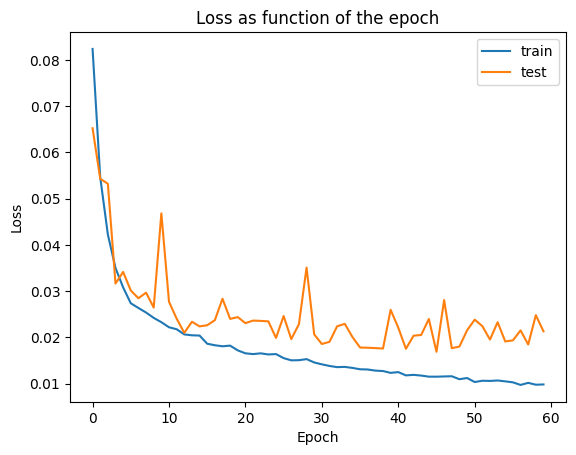

In [22]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss as function of the epoch")
#plt.xticks(np.arange(0, len(losses_train)))
plt.plot(losses_train, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.savefig("Losses_model_transform")


In [17]:
train_loader, test_loader, inv_classes = load_data()

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


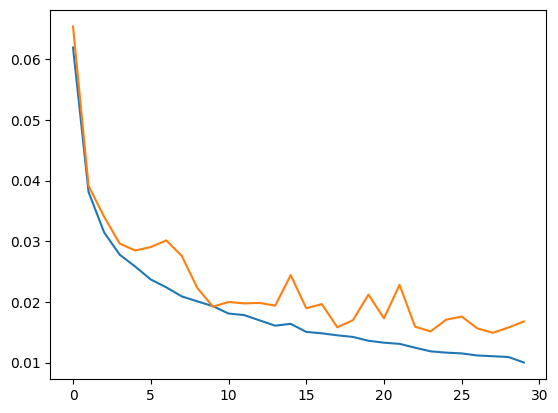

In [19]:
plt.plot(losses_train)
plt.plot(losses_test)

## Adding the normals

We'll compute the normals of all the points, thus creating point clouds of dimension 6.

In [29]:
train_loader, test_loader, inv_classes = load_data(transforms = default_transforms)

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


In [14]:
model = DGCNN(len(inv_classes)).to(device)
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 100,
                                              gamma = 0.9, lr = 1e-2, step_size = 5, save_step = 5, patience = 2, model_name = "k10")

  0%|                                                                                           | 0/100 [00:04<?, ?it/s]

Interruption


## DGCNN With attention

In [15]:
class AttentionEdgeConv(nn.Module):
    
    def __init__(self,start_dim, end_dim,  k, momentum = 0.1):
        super(AttentionEdgeConv, self).__init__()
        self.k = k
        self.attention = nn.Sequential(
            nn.Conv2d(start_dim, end_dim // 4, 1),
            nn.BatchNorm2d(end_dim // 4),
            nn.ReLU(),
            nn.Conv2d(end_dim // 4, 1, 1),
            nn.Sigmoid())
        self.conv1 = nn.Sequential( 
                        nn.Conv2d(start_dim , end_dim, 1),
                        nn.BatchNorm2d(end_dim, momentum = momentum),
                        nn.ReLU())
    def forward(self, x):
        feature = build_graph(x, self.k) # B x 2F x N x k
        attention_scores = self.attention(feature) # B x 1 x N x k
        feature = self.conv1(feature) # B x F' x N x k
        feature = feature * (attention_scores) # B * F' * N * k
        return feature.sum(dim = -1, keepdim = False).transpose(1, 2)

class DGCNN_with_attention(nn.Module):
    def __init__(self, output_channels, k = 5, dropout = 0.3, momentum = 0.1):
        super(DGCNN_with_attention, self).__init__()
        self.conv1 = EdgeConv(6, 64, k, momentum = momentum)
        self.conv2 = EdgeConv(64*2, 64, k, momentum = momentum)
        self.conv3 = EdgeConv(64 *2, 64 , k, momentum = momentum)
        self.conv3 = AttentionEdgeConv(64*2, 128, k, momentum = momentum)
        self.conv4 = AttentionEdgeConv(128 * 2, 256, k, momentum = momentum)
        self.conv5 = nn.Sequential(nn.Conv1d(512, 1024, 1),
                                   nn.BatchNorm1d(1024, momentum = momentum),
                                   nn.ReLU())
        self.mlp = nn.Sequential(
            nn.Linear(1024 * 2, 512),
            nn.BatchNorm1d(512, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256, momentum = momentum),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_channels,)
        )
    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        
        x4 = self.conv4(x3)
        x5 = torch.concat((x1, x2, x3, x4), dim = -1).transpose(1, 2)
        x5 = self.conv5(x5)
        X1 = F.max_pool1d(x5, 1024).squeeze(-1)
        X2 = F.avg_pool1d(x5, 1024).squeeze(-1)
        return self.mlp(torch.cat((X1, X2), dim = -1)), None

In [16]:
train_loader, test_loader, inv_classes = load_data(transforms = my_transform)

Device:  cuda:0
torch.Size([1024, 3])
torch.Size([1024, 3])
Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])


In [19]:
model = DGCNN_with_attention(40, 5, dropout = 0.5).to(device)

In [21]:
losses_train, losses_test, accuracies = train(model, train_loader, test_loader, n_epochs = 100, lr = 1e-2, step_size = 5,
          gamma = 0.8, model_name = "attention",)

Epoch 99: 100%|███████████████| 100/100 [1:54:44<00:00, 68.84s/it, accuracy=0.877, loss_test=0.0132, loss_train=0.00782]


In [23]:
print(f"Accuracy max : {np.max(accuracies):.4f}")

Accuracy max : 0.8798


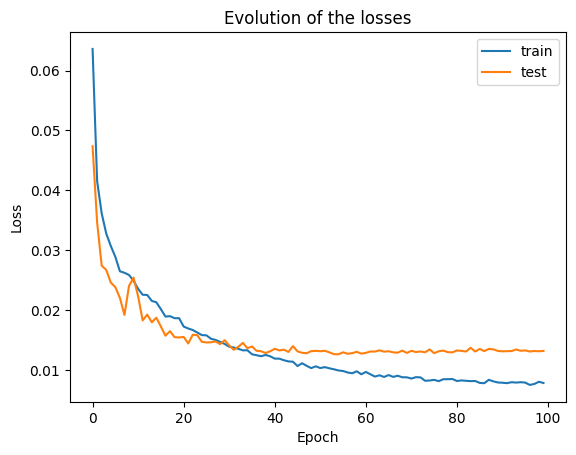

In [26]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the losses")
plt.plot(losses_train, label = "train")
plt.plot(losses_test, label = "test")
plt.legend()
plt.savefig("Losses_attention")

/tmp/ipykernel_311934/1101534558.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


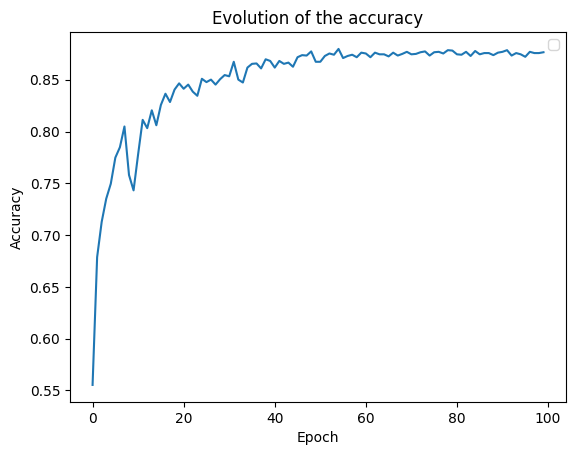

In [32]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolution of the accuracy")

plt.plot(accuracies)
plt.legend()

plt.savefig("Accuracy_attention")

In [17]:
model = DGCNN_with_attention(40, 5).to(device)
model.load_state_dict(torch.load("models/attention/Model.pth"))
model.eval()

DGCNN_with_attention(
  (conv1): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv2): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv3): AttentionEdgeConv(
    (attention): Sequential(
      (0): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      (4): Sigmoid()
    )
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
 

In [20]:
evaluate(model, test_loader)

(0.012616688065201323, 0.8798076923076923)

In [235]:
def Grad_CAM(label, pointcloud, conv_layer, model):
    """
    Computes the heatmap showing where the network is focused.
    ---Args:
        - label (int or str) : the corresponding index of the label, or the name of the label.
        - pointcloud (tensor) : the point cloud to process.
        - conv_layer (Conv2d) : the layer that we'll use to get the semantic output (in the paper, it's the last convolutional layer).
    """
    model.zero_grad()
    feature_map = []
    # Put the intermediate feature map outputed by module in feature_map list
    def forward_hook(module, inputs, outputs):
        feature_map.append(outputs)
    
    handle = conv_layer.register_forward_hook(forward_hook)
    output = model(pointcloud)[0]
    handle.remove()
    # Feature_map yielded by the conv_layer
    feature_map = feature_map[0]
    # We'll compute the derivative of the output for the corresponding label wrto the feature map
    feature_map.retain_grad()
    output[0, label].backward()
    gradient = feature_map.grad.squeeze(0)
    feature_map = feature_map.squeeze(0)
    # As seen in the paper, the coefficients alpha are the coefficients we use to weights the feature maps.
    alpha = torch.mean(gradient, axis = 0).flatten()
    # We merge all the features maps with their corresponding weights and then use ReLU
    heatmap = torch.zeros(feature_map.shape[0])
    for i in range(alpha.shape[0]):
        heatmap += alpha[i] * feature_map[:, i]
    #heatmap = F.relu(torch.sum(alpha * feature_map, axis = -1) )
    heatmap = F.relu(heatmap)
    heatmap_max = heatmap.max()
    heatmap_min = heatmap.min()
    if heatmap_max > heatmap_min:
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
    return heatmap.detach().numpy()


IndentationError: expected an indented block after 'if' statement on line 35 (3817450407.py, line 36)

In [259]:
model_without_attention

DGCNN(
  (conv1): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv2): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv3): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv4): EdgeConv(
    (conv1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv5): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
  

In [265]:
model_without_attention = DGCNN(len(inv_classes)).to(device)
model_without_attention.load_state_dict(torch.load("models/Model_base_ours/Model_base_95.pth"))

RuntimeError: Error(s) in loading state_dict for DGCNN:
	Missing key(s) in state_dict: "transform.conv2.0.weight", "transform.conv2.0.bias", "transform.conv2.1.weight", "transform.conv2.1.bias", "transform.conv2.1.running_mean", "transform.conv2.1.running_var", "transform.mlp.1.weight", "transform.mlp.1.bias", "transform.mlp.1.running_mean", "transform.mlp.1.running_var", "transform.mlp.3.weight", "transform.mlp.3.bias". 
	Unexpected key(s) in state_dict: "transform.mlp.2.weight", "transform.mlp.2.bias". 
	size mismatch for transform.mlp.0.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for transform.mlp.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [209]:
label

tensor(24)

In [200]:
data = next(iter(train_loader))
pointcloud, label = data["pointcloud"].cpu().float()[0], data["category"][0].cpu().long()

In [201]:
label

tensor(24)

In [236]:
heat = Grad_CAM(label, pointcloud.unsqueeze(0), model.conv1, model )

In [138]:
device = "cpu"

In [128]:
model = model.cpu()

In [252]:
heat = GradCAM_PointCloud(model, pointcloud.unsqueeze(0), label, model.conv4)

In [253]:
write_ply('../Lille_street_small_normals.ply', (pointcloud.numpy(), heat.flatten() ), ['x', 'y', 'z', "c"])

True

In [245]:
model.conv1

EdgeConv(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [177]:
(heat - heat.min() ) / (heat.max() - heat.min())

array([[0.42061272, 0.39862466, 0.50365144, ..., 0.38565108, 0.38766328,
        0.39885762]], dtype=float32)

In [243]:
heat.mean()

0.0